<!DOCTYPE html>
<html lang="fr">
<head>
    <meta charset="UTF-8">
    <title>Extraction de Trajectoires</title>
    <style>
        h1 {
            color: skyblue;
            font-size: 30px;
            font-weight: bold; /* Notez que c'est 'font-weight' et non 'font-style' pour le gras */
        }
        .red-text {
            color: red;
        }
        .green-text {
            color: DarkSeaGreen;
        }
    </style>
</head>
<body>
    <h1>Extraction de Trajectoires pour Étude</h1>
    <p>L'objectif de ce processus est de lire le document de tracking afin d'extraire uniquement les trajectoires spécifiques à étudier. Cela permet de préparer un fichier final des trajectoires qui sera utilisé dans l'analyse ultérieure, évitant ainsi des complications liées aux variations de paramètres entre différentes manipulations (telles que la luminosité et la taille).</p>
    <p>Cette approche assure que toutes les données nécessaires sont directement disponibles dans le fichier final, éliminant le besoin de retravailler les fichiers ultérieurement et de résoudre des problèmes causés par des paramètres hétérogènes.</p>
    <ol>
        <li><strong class="green-text">Chargement du fichier :</strong> Charger le fichier de la manipulation que l'on souhaite étudier.</li>
        <li><strong class="green-text">Création des trajectoires :</strong> Traitement des données pour créer les trajectoires d'intérêt.</li>
        <li><strong class="green-text">Triage des données :</strong> Trier les trajectoires pour ne conserver que celles pertinentes à l'étude.</li>
        <li><strong class="green-text">Enregistrement du nouveau fichier :</strong> Sauvegarder les trajectoires sélectionnées dans un nouveau fichier qui sera utilisé pour les analyses futures.</li>
    </ol>
</body>
</html>


In [26]:
import pandas as pd
import os
import re
import trackpy as tp
import matplotlib.pyplot as plt
import imageio.v2 as imageio

In [27]:
def remove_drift(traj, smooth, save=False, pathway_saving=None, name=None, img_type="jpg"):
    """
    Remove overall drift motion.

    Remove overall drift motion from trajectories by adopting
    the referenceframe of the particles' average position.

    Parameters
    ----------
    traj : pd.DataFrame
        DataFrame containing the trajectories.
    smooth : int
        Smoothing value used to smooth the drift curves.

    Returns
    -------
    corrected_traj : pd.DataFrame
        DataFrame containing the corrected trajectories.
    """
    # Calculate drift
    drift = tp.compute_drift(traj, smooth)

    # Plot drift curves
    plt.figure(figsize=(20, 20))
    drift.plot(color=['blue', 'red'], linestyle='dotted')

    # Add title and axis labels
    plt.title(f'Drift Curves of {name}', fontsize=40,
              fontweight="bold", fontstyle='italic', fontname="Arial")
    plt.xlabel('Frame number', fontsize=16, fontstyle='italic')
    plt.ylabel('Drift (pixel)', fontsize=14, color='red')

    # Add grid
    plt.grid()

    # Set axis limits
    plt.xlim([0, traj['frame'].max()])
    plt.ylim([-10, 10])

    plt.tight_layout()
    # plt.clf()
    # plt.close()
    if save:
        if pathway_saving is not None:
            plt.savefig(pathway_saving+f'drift{name}.' + img_type,
                        format=img_type, dpi=None, bbox_inches='tight')
        else:
            save = False
    # Correct trajectories by subtracting the drift
    corrected_traj = tp.subtract_drift(traj, drift)
    plt.show()
    plt.close()

    return corrected_traj

In [28]:
def read_hdf5_single_file(filepath: str, condition: str, manip_name: str, name_file: str = 'features',
                          nbr_frame_min: int =200, drift=False, search_range: int = 100,
                          memory: int = 5, adaptive_stop: int = 30, min_mass_raw: int = 1000, max_size: int = 40):
    """
    Read a single traj hdf5 file.

    Parameters
    ----------
    filepath : string
        absolute path to the traj hdf5 file.
    condition : str
        specific condition of the experiment.

    Returns
    -------
    data : pd.DataFrame
        DataFrame of the trajectories info, with new columns (particle positions, and experiment name)

    """
    # Initialize an empty DataFrame
    data = pd.DataFrame()
    
    # Checking if the file exists and matches the criteria
    filepath = os.path.join(filepath, name_file + '.hdf5')
    if filepath.endswith(".hdf5") and name_file in filepath:
        try:
            data = pd.read_hdf(filepath, key='table')
            print(data)
        except ValueError as e:
            print(f"Error reading {filepath}: {e}")
            return pd.DataFrame()  # Return empty DataFrame in case of error

        # Apply linking if 'features' file
        if name_file == 'features' and 'particle' not in data.columns:
            data = tp.link_df(data, search_range=search_range, memory=memory,
                              neighbor_strategy='KDTree', link_strategy='auto',
                              adaptive_stop=adaptive_stop)
        
        # Filter data based on mass and size if columns exist
        if 'size' in data.columns and 'mass' in data.columns and 'raw_mass' in data.columns:
            mean_mass_by_particle = data.groupby('particle')['raw_mass'].mean()
            particles_to_keep = mean_mass_by_particle[mean_mass_by_particle > min_mass_raw].index
            data = data[data['particle'].isin(particles_to_keep)]

        # Filter particles based on the minimum number of frames
        counts = data.groupby(['particle']).size()
        particles_to_keep = counts[counts >= nbr_frame_min].reset_index(name='count')
        data = data.merge(particles_to_keep, on=['particle'])
        data['experiment'] = manip_name
        data['condition'] = condition
        
        # Assuming remove_drift is a function defined elsewhere if needed
        if drift:
            data = remove_drift(traj=data, smooth=2, save=True, pathway_saving=os.path.dirname(filepath),
                                name=manip_name)
            data = data.drop('frame', axis=1).reset_index(drop=True)
            


    print(manip_name, " : ", data['particle'].nunique())
    # print("Nombre de particules récoltées avant tri: ", data_all['particle'].nunique())
    return data

<center><span style="color: skyblue; font-size: 30px; font-style: bold"> Mise en place des chemin d'expériences et images, définitions de la condition d'étude</span></center>

In [29]:
PATHWAY_EXPERIMENTS= '/Users/souchaud/Desktop/Analyses/'
PATHWAY_PICTURES= '/Users/souchaud/Desktop/A_analyser/'
CONDITION='CytoOne_HL5_10x'
MANIP='ASMOT156'
PATHWAY=os.path.join(PATHWAY_EXPERIMENTS, CONDITION + '_new_param/')
# Parcourir les dossiers dans PATHWAY
for dir_name in os.listdir(PATHWAY):
    if MANIP in dir_name:
        MANIP_NAME = dir_name
        break
PATHWAY_RESULTS = os.path.join(PATHWAY, MANIP_NAME)
PATHWAY_RESULTS = os.path.join(PATHWAY_RESULTS, 'mosaic/')
print(PATHWAY_RESULTS)

PATHWAY_PICTURES= os.path.join(PATHWAY_PICTURES, CONDITION + '_faits')
# Parcourir les dossiers dans PATHWAY
for dir_name in os.listdir(PATHWAY_PICTURES):
    if MANIP in dir_name:
        PATHWAY_PICTURES = os.path.join(PATHWAY_PICTURES, dir_name, 'mosaic/')
        break
print(PATHWAY_PICTURES)

/Users/souchaud/Desktop/Analyses/CytoOne_HL5_10x_new_param/2024_04_30_ASMOT156_AX3_2024_P4_10x_CytoOne_HL5_2604-10h30_3004_14h55/mosaic/
/Users/souchaud/Desktop/A_analyser/CytoOne_HL5_10x_faits/2024_04_30_ASMOT156_AX3_2024_P4_10x_CytoOne_HL5_2604-10h30_3004_14h55/mosaic/


<center><span style="color: skyblue; font-size: 30px; font-style: bold"> Paramètres d'étude</span></center>

In [30]:
FILE_NAME='features'
N_FRAME_MIN_STUDY = 150
DRIFT = False
SEARCH_RANGE = 30
MEMORY = 5
MIN_MASS_RAW = 500
MAX_SIZE = 20
ADAPTIVE_STOP = 15

<center><span style="color: skyblue; font-size: 30px; font-style: bold"> Lectures des données</span></center>

In [31]:
DATA = read_hdf5_single_file(filepath=PATHWAY_RESULTS, manip_name=MANIP, 
                             name_file=FILE_NAME, nbr_frame_min=N_FRAME_MIN_STUDY, condition=CONDITION, drift=DRIFT,
                             search_range=SEARCH_RANGE, memory=MEMORY, min_mass_raw=MIN_MASS_RAW, 
                             adaptive_stop=ADAPTIVE_STOP, max_size=MAX_SIZE)

Frame 339: 336 trajectories present.
ASMOT156  :  266


<center><span style="color: skyblue; font-size: 30px; font-style: bold"> Plot final des trajectoires</span></center>

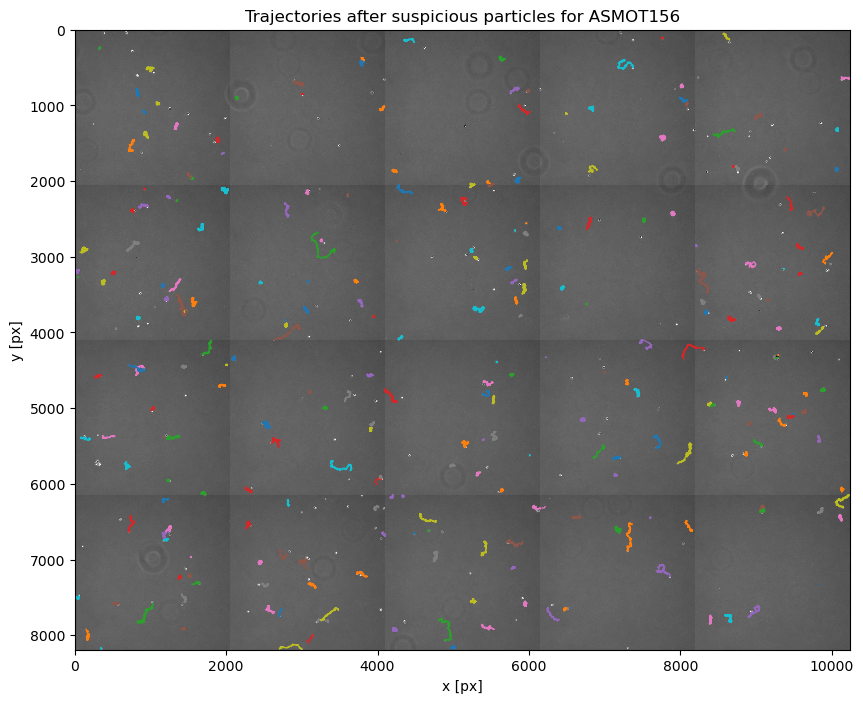

In [32]:
# Construction du chemin complet vers l'image à utiliser comme fond
image_path_directory = f'{PATHWAY_PICTURES}/mosaic_total_0.tif'  # Ajustez selon le nom de fichier et le chemin d'accès réel

# Lecture de l'image
frame = imageio.imread(image_path_directory)

# Créer la figure et les axes pour le sous-graphique
fig, ax = plt.subplots(figsize=(10, 10))  # Ajustez la taille selon vos besoins

# Tracer les trajectoires sur l'image
ax.set_aspect('equal', 'box')
ax.set_title(f'Trajectories after suspicious particles for {MANIP}')
tp.plot_traj(DATA, superimpose=frame, label=False, ax=ax)

# Afficher le graphique
plt.show()

<center><span style="color: skyblue; font-size: 30px; font-style: bold"> Enregistrement des données en hdf5</span></center>

In [33]:
DATA.to_hdf(os.path.join(PATHWAY_RESULTS, 'filtered_final.hdf5'), 'table')

In [34]:
DATA

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle,count,experiment,condition
0,5531.197061,7682.231195,1057.634156,4.244428,0.381558,14.875070,26460.0,0.061878,0,4,340,ASMOT156,CytoOne_HL5_10x
1,5527.680161,7686.956663,1232.224264,4.310135,0.299653,16.148261,27634.0,0.055387,1,4,340,ASMOT156,CytoOne_HL5_10x
2,5529.605163,7682.819858,1181.533424,4.338485,0.317969,15.007185,27752.0,0.054772,2,4,340,ASMOT156,CytoOne_HL5_10x
3,5529.626953,7680.949735,1151.110374,4.248944,0.295747,15.637962,26973.0,0.058832,3,4,340,ASMOT156,CytoOne_HL5_10x
4,5528.848733,7679.117238,1297.967112,4.309442,0.223606,16.281008,28008.0,0.053569,4,4,340,ASMOT156,CytoOne_HL5_10x
...,...,...,...,...,...,...,...,...,...,...,...,...,...
74980,1887.864271,1490.331767,1229.640565,3.867636,0.231450,21.076876,26203.0,0.063958,335,2076,151,ASMOT156,CytoOne_HL5_10x
74981,1887.467876,1491.216851,1283.181835,3.911361,0.225347,22.005604,27116.0,0.058479,336,2076,151,ASMOT156,CytoOne_HL5_10x
74982,1887.552210,1492.992526,1486.007310,4.011074,0.260658,23.661512,27046.0,0.058886,337,2076,151,ASMOT156,CytoOne_HL5_10x
74983,1887.308200,1493.907820,1391.650978,4.046090,0.274760,21.172898,26566.0,0.061748,338,2076,151,ASMOT156,CytoOne_HL5_10x
